In [ ]:
import random
from scipy.ndimage import zoom

class Float(DualTransform):
    def apply(self, image):
        return image.astype(np.float32)

class Contiguous(DualTransform):
    def apply(self, image):
        return np.ascontiguousarray(image)

class Compose:
    def __init__(self, transforms, p=1.0, targets=[['image'],['mask']]):
        assert 0 <= p <= 1
        self.transforms = [Float(always_apply=True)] + transforms + [Contiguous(always_apply=True)]
        self.p = p
        self.targets = targets

    def get_always_apply_transforms(self):
        res = []
        for tr in self.transforms:
            if tr.always_apply:
                res.append(tr)
        return res

    def __call__(self, force_apply=False, **data):
        need_to_run = force_apply or random.random() < self.p
        transforms = self.transforms if need_to_run else self.get_always_apply_transforms()

        for tr in transforms:
            data = tr(force_apply, self.targets, **data)

        return data

def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class Transform:
    def __init__(self, always_apply=False, p=0.5):
        assert 0 <= p <= 1
        self.p = p
        self.always_apply = always_apply

    def __call__(self, force_apply, targets, **data):
        if force_apply or self.always_apply or random.random() < self.p:
            params = self.get_params(**data)

            for k, v in data.items():
                if k in targets[0]:
                    data[k] = self.apply(v, **params)
                else:
                    data[k] = v

        return data

    def get_params(self, **data):
        """
        shared parameters for one apply. (usually random values)
        """
        return {}

    def apply(self, volume, **params):
        raise NotImplementedError

class DualTransform(Transform):
    def __call__(self, force_apply, targets, **data):
        if force_apply or self.always_apply or random.random() < self.p:
            params = self.get_params(**data)


            for k, v in data.items():
                if k in targets[0]:
                    data[k] = self.apply(v, **params)
                elif k in targets[1]:
                    data[k] = self.apply_to_mask(v, **params)
                else:
                    data[k] = v

        return data

    def apply_to_mask(self, mask, **params):
        return self.apply(mask, **params)

def resize(img, new_shape, interpolation=1, resize_type=0):
    """
    img: [H, W, D, C] or [H, W, D]
    new_shape: [H, W, D]
    interpolation: The order of the spline interpolation (0-5)
    resize_type: what type of resize to use: scikit-image (0) or zoom (1)
    """

    if resize_type == 0:
        new_img = skt.resize(
            img,
            new_shape,
            order=interpolation,
            mode='reflect',
            cval=0,
            clip=True,
            anti_aliasing=False
        )
    else:
        shp = tuple(np.array(new_shape) / np.array(img.shape[:3]))

        if len(img.shape) == 4:
            # Multichannel
            data = []
            for i in range(img.shape[-1]):
                subimg = img[..., i].copy()
                d0 = zoom(subimg, shp, order=interpolation)
                data.append(d0.copy())
            new_img = np.stack(data, axis=-1)
        else:
            new_img = zoom(img.copy(), shp, order=interpolation)

    return new_img

class Resize(DualTransform):
    def __init__(self, shape, interpolation=1, resize_type=1, always_apply=False, p=1):
        super().__init__(always_apply, p)
        self.shape = shape
        self.interpolation = interpolation
        self.resize_type = resize_type

    def apply(self, img):
        return resize(img, new_shape=self.shape, interpolation=self.interpolation, resize_type=self.resize_type)

    def apply_to_mask(self, mask):
        return resize(mask, new_shape=self.shape, interpolation=0, resize_type=self.resize_type)

def get_aug():
    return Compose([
        Resize((2,3,2))
    ]
    )

aug = get_aug()

data = {
    "image": np.ones((5,5,5)),
    "mask": np.zeros((5,5,5))
}

for i in range(10):
    aug_data = aug(**data)
    img, lbl = aug_data['image'], aug_data['mask']
    print(img.shape, lbl.shape, np.max(img), np.max(lbl))


Patches do not divide by the patch shape. Padding image
(0, 0, 0, 0, 0, 0)
torch.Size([8, 12, 1023, 256])


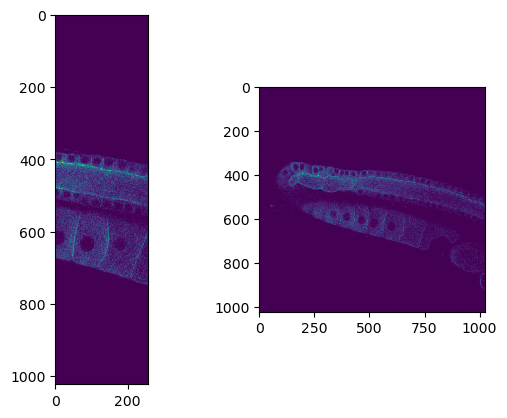

In [219]:
# Creating patches

import skimage
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

im_path = "/Users/ctromans/image-analysis/threedee_nn/data/images/mx85-nd-acqusition-0-ch2.tif"

image = skimage.io.imread(im_path).astype(np.float32)

image = torch.from_numpy(image)

# # 
# image = torch.unsqueeze(image, axis=0)

def generate_patches(image, patch_shape):
    """Generate patches of the desired shape with strides between
    patches.

    Patch shape and stride shape are in order (D, W, H). 
    
    Output tensor with order: (patch, D, W, H)
    """
    # Only non-overlapping patches, for now. 
    stride_shape = patch_shape

    if not torch.is_tensor(image):
        raise TypeError("Input is not a Tensor.")

    # Check that the image dimensions divide cleanly into the patch shape
    # If not, pad the image. 
    if any([
        image.shape[0] % patch_shape[0],
        image.shape[1] % patch_shape[1],
        image.shape[2] % patch_shape[2]]):
        print("Patches do not divide by the image shape. Padding image.")
        image = F.pad(
            image,
            (image.size(2)%patch_shape[2] // 2, image.size(2)%patch_shape[2] // 2,
            image.size(1)%patch_shape[1] // 2, image.size(1)%patch_shape[1] // 2,
            image.size(0)%patch_shape[0] // 2, image.size(0)%patch_shape[0] // 2)
            )
    # Add an extra dimension that will hold the patches
    image = torch.unsqueeze(image, axis=0)
    # Unfold the 1st dimension with size patch_shape[0] with stride_shape[0]
    # Unfold slides along in the provided dimension providing the desired patches
    patches = image.unfold(
        1, patch_shape[0], stride_shape[0]
        ).unfold(
            2, patch_shape[1], stride_shape[1]
            ).unfold(
                3, patch_shape[2], stride_shape[2]
                )
    unfold_shape = patches.size()
    patches = patches.contiguous().view(-1, patch_shape[0], patch_shape[1], patch_shape[2]) 
    return patches, unfold_shape

def reconstruct_patches(patches, unfold_shape):
    """Undo patches. Patch and stride shape must be equal"""
    original_patches = patches.view(unfold_shape)
    depth = unfold_shape[1] * unfold_shape[4]
    width = unfold_shape[2] * unfold_shape[5]
    height = unfold_shape[3] * unfold_shape[6]
    original_patches = original_patches.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    original_patches = original_patches.view(1, depth, width, height)
    return original_patches

patches, unfold_shape = generate_patches(image, (12, 1023, 256))

reconstruction = reconstruct_patches(patches, unfold_shape)

print(patches.shape)

fig, ax = plt.subplots(1, 2)

# Understanding the dims
# [batch?, z?, ]
ax[0].imshow(patches.numpy()[6, 5,...])
ax[1].imshow(reconstruction[0,20,...])


In [294]:
d = {
    "image": 1,
    "mask": 2
}

eval(**d)

TypeError: eval() takes no keyword arguments

In [14]:
%load_ext autoreload
%autoreload 2
from threedee.utils.data_utils import generate_patches, save_patches
import torch
import skimage
import numpy as np

img = skimage.io.imread("/Users/ctromans/image-analysis/threedee_nn/data/images/mx85-nd-acqusition-0-ch1.tif").astype(np.float32)

img = torch.from_numpy(img)

patches = generate_patches(img, patch_shape=(24, 512, 512), stride_shape=(24, 256, 256))

save_patches(patches, "test_filename.tiff", "hello")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pandas as pd
import torch
import os
import pathlib

from threedee.utils.data_utils import generate_patches, save_patches

load_data = pd.read_csv("./data/data.csv")

patch_shape = (24, 200, 200)
stride_shape = (24, 100, 100)

save_df = {
    "image": [],
    "label": []
    }

for im, ma in zip(load_data.iloc[:, 0].values, load_data.iloc[:, 2].values):
    image = torch.from_numpy(skimage.io.imread(im).astype(np.float32))
    image_filename = os.path.basename(im)
    image_patches = generate_patches(image, patch_shape=patch_shape, stride_shape=stride_shape)
    image_save_paths = save_patches(image_patches, image_filename, "./patch_data/image")

    save_df["image"].extend(image_save_paths)

    mask = torch.from_numpy(skimage.io.imread(ma).astype(np.float32))
    mask_filename = os.path.basename(ma)
    mask_patches = generate_patches(mask, patch_shape=patch_shape, stride_shape=stride_shape)
    mask_save_paths = save_patches(mask_patches, mask_filename, "./patch_data/labels")

    save_df["label"].extend(mask_save_paths)

save_df = pd.DataFrame.from_dict(save_df, orient="index").transpose()
save_df.to_csv("./patch_data/load_data.csv", index=False)

Patches do not divide by the image shape. Padding image.
Patches do not divide by the image shape. Padding image.


/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch1.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch2.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch3.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch4.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch5.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/m

Patches do not divide by the image shape. Padding image.
Patches do not divide by the image shape. Padding image.


/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch4.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch5.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch6.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch7.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch8.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/m

Patches do not divide by the image shape. Padding image.
Patches do not divide by the image shape. Padding image.


/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch1.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch2.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch8.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch9.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch10.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/

In [58]:
from torch.autograd import Variable


x = Variable(torch.randn(1, 22, 10, 10))
y = Variable(torch.LongTensor(1, 10, 10).random_(22))

criterion = torch.nn.NLLLoss()

loss = criterion(x, y)

# Binary example
x = torch.sigmoid(Variable(torch.randn(1, 1, 10, 10)))
y = Variable(torch.FloatTensor(1, 1, 10, 10).random_(2))

print(x.shape, y.shape)

criterion = torch.nn.BCELoss()

loss = criterion(x, y)

loss

torch.Size([1, 1, 10, 10]) torch.Size([1, 1, 10, 10])


tensor(0.8241)

Error found:

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Traceback (most recent call last):
  File "/var/lib/condor/execute/slot1/dir_4434/UNet_3D_C_elegans/run_training.py", line 245, in <module>
    trainer.fit()
  File "/var/lib/condor/execute/slot1/dir_4434/UNet_3D_C_elegans/run_training.py", line 129, in fit
    current_val_loss = self.validate()
  File "/var/lib/condor/execute/slot1/dir_4434/UNet_3D_C_elegans/run_training.py", line 200, in validate
    loss = self.loss_fn(prediction, y)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/var/lib/condor/execute/slot1/dir_4434/UNet_3D_C_elegans/unet/utils/loss.py", line 51, in forward
    output = self.bce(prediction, target.float()) + self.dice(prediction, target)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py", line 720, in forward
    return F.binary_cross_entropy_with_logits(input, target,
  File "/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py", line 3160, in binary_cross_entropy_with_logits
    raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
ValueError: Target size (torch.Size([1, 1, 24, 200, 200])) must be the same as input size (torch.Size([1, 2, 24, 200, 200]))

In [56]:
import numpy as np
import pandas as pd
import skimage
import sys
sys.path.append("../")
from unet.utils.load_data import MaddoxDataset
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/ctromans/image-analysis/UNet_3D_C_elegans/patch_data/load_data_training.csv")

df.iloc[:, 0] = "../" + df.iloc[:, 0].astype(str)
df.iloc[:, 1] = "../" + df.iloc[:, 1].astype(str)


train_ds = MaddoxDataset(
    data_csv=df,
    train_val="train"
)

for i, data in enumerate(train_ds):
    print(data["image"].shape, data["mask"].shape)



torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size([2, 24, 200, 200])
torch.Size([1, 24, 200, 200]) torch.Size